# Parameters

In [ ]:
from sys import version_info
py3 = version_info >= (3,0)

seed = 70 # seed for NMF topic model
num_topics = 10
query = 'title-abs-key("evolving neural network" AND ("deep learning" OR "object recognition"))' #'title-abs-key("exascale")'
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
vis_seed = 6 # seed for t-SNE visualization
vis_angle = 135 # rotation angle for visualization

# Imports

In [ ]:
import random
import gensim
import scopus
import numpy as np
import yaml
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets

from IPython.display import display
from collections import defaultdict

import seaborn as sns
sns.set('paper')


import logging
logging.getLogger().setLevel(logging.INFO)

In [ ]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    plt.figure(figsize=figsize)
    plt.clf()
    
def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

# Perform query

In [ ]:
eids = scopus.ScopusSearch(query).EIDS
random.seed(0)
random.shuffle(eids)

bar = widgets.IntProgress(
    min=0, 
    max=len(eids), 
    description='Loading')
display(bar)

print('query: {} ({} results)'.format(query, len(eids)))

papers = []
for eid in eids:
    papers.append(scopus.ScopusAbstract(eid, view='FULL'))
    bar.value += 1
print('scopus returned {} results'.format(len(papers)))

# ar = article, cp = conference proceeding, re = review
papers = [p for p in papers if p.citationType in ('ar', 'cp', 're')]
#papers = [p for p in papers if int(p.coverDate[:4]) <= 2018]

print('{} papers remaining'.format(len(papers)))

In [ ]:
texts = []
for p in papers:
    text = (p.title or '') + ' ' + (p.abstract or '')
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    text = filter(None, text.split(' '))
    if py3:
        text = list(text)
    texts.append(text) # Split on spaces, remove empty items

# Analysis

In [ ]:
# Publications per year
year_count = defaultdict(int)

for p in papers:
    year_count[int(p.coverDate[:4])] += 1
       
years = range(2000, 2020)

prepare_fig(2.5, 1)
plt.xlabel("No. publications")
plt.bar(
    years,
    [year_count[y] for y in years])
plt.xticks(years);

In [ ]:
# Publications per aggregation type
def plot_statistic(fun):
    count = defaultdict(int)

    for p in papers:
        for key in fun(p):
            if not py3:
                key = unicode(key)
            if key:
                count[key] += 1

    top_keys = top_k(count, 50)

    prepare_fig(1, 4)
    plt.xlabel("No. publications")
    plt.barh(
        range(len(top_keys)),
        [count[a] for a in top_keys])
    plt.yticks(
        range(len(top_keys)), 
        [key[:50] for key in top_keys])
    plt.show()
    
plot_statistic(lambda p: [p.aggregationType])

In [ ]:
# Publications per author
plot_statistic(lambda p: set(a.indexed_name for a in p.authors))

In [ ]:
# Publications per institute
def clean_affiliation(name):
    if not py3:
        name = unicode(name)
    name = name.title()
    pairs = [
        ['University', 'U'],
        ['Universitat', 'U'],
        ['Laboratories', 'Lab'],
        ['Laboratory', 'Lab'],
        ['National', 'Nat'],
        ['Corporation', 'Corp'],
        ['Technology', 'Tech'],
        ['Institute', 'Inst'],
    ]
    
    for needle, replacement in pairs:
        name = name.replace(needle, replacement)
    return name

plot_statistic(lambda p: set(clean_affiliation(a.affilname) for a in p.affiliations))

In [ ]:
# Publications per publication source, conference/journal (TODO: cleaning!)
plot_statistic(lambda p: [p.publicationName])

# Topic Modeling
## Preprocessing

In [ ]:
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        for line in f:
            if line.strip():
                stopwords.add(line.strip())
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

In [ ]:
# Print common words and bigrams
one_count = defaultdict(int)
two_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1

print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'stopword?']))

print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'bigram?']))


In [ ]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [ ]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [15]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(token, stemming[token], unstemming[stemming[token]], word_count[token]) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

INFO:root:stemming reduced 3558 to 2316 tokens


,Original,Stem,Unstem,Count
0,data,data,data,381
1,pdm,pdm,pdm,265
2,machinelearning,machinelearn,machinelearning,184
3,maintenance,mainten,maintenance,152
4,model,model,model,124
5,system,system,system,117
6,analysis,analysi,analysis,91
7,prediction,predict,prediction,84
8,models,model,model,81
9,methods,method,methods,81


## Create dictionary

In [16]:
# Remove papers with less than 50 words after preprocessing
n = len(papers)
indices = [i for i in range(len(papers)) if len(stemmed_texts[i]) > 50]
papers = [papers[i] for i in indices]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(papers)))

papers: 151 (removed 8)


In [17]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(2293 unique tokens: ['advanced', 'analysed', 'annotations', 'article', 'asset']...) from 151 documents (total 15950 corpus positions)
INFO:gensim.corpora.dictionary:discarding 6 tokens: [('prediction', 90), ('system', 81), ('pdm', 132), ('data', 123), ('model', 83), ('machinelearning', 105)]...
INFO:gensim.corpora.dictionary:keeping 2287 tokens which were in no less than 0 and no more than 75 (=50.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(2287 unique tokens: ['advanced', 'analysed', 'annotations', 'article', 'asset']...)
INFO:gensim.corpora.dictionary:discarding 1707 tokens: [('annotations', 1), ('blazing', 1), ('collaborative', 2), ('despite', 3), ('difficult', 4), ('entitled', 1), ('eu', 1), ('european', 2), ('facilitate', 3), ('floor', 4)]...
INFO:gensim.corpora.dictionary:keeping 580 tokens which were in no less tha

papers: 151
dictionary size: 580


## Topic modeling

In [18]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq
        

In [19]:
# Run TFIDF model
tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()

In [20]:
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

violation: 1.0
violation: 0.4579707520754636
violation: 0.3287195979259072
violation: 0.2566462655598634
violation: 0.19713723624132704
violation: 0.15102639801154133
violation: 0.11461517241830885
violation: 0.0892657609809287
violation: 0.07159099471041923
violation: 0.05899134155314721
violation: 0.04972161152063858
violation: 0.04195051032641573
violation: 0.0361331932902033
violation: 0.03136662913518342
violation: 0.027555704872152115
violation: 0.02437358878804488
violation: 0.021698754167822555
violation: 0.01941923714039201
violation: 0.01763284574611861
violation: 0.01615654991408693
violation: 0.01490441203645994
violation: 0.013833414720527275
violation: 0.012813169118332543
violation: 0.011823110434970948
violation: 0.010904355059820313
violation: 0.010119437763528746
violation: 0.009341928184637497
violation: 0.008645242209324623
violation: 0.008040494966261505
violation: 0.007484086579500092
violation: 0.006993743681691878
violation: 0.006497952234694734
violation: 0.006

In [21]:
rows = []

for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,industrial (0.049),machine (0.042),sensor (0.023),manufacturing (0.017),smart (0.017),equipment (0.016),architecture (0.015),environment (0.013),tools (0.012),iiot (0.012)
1,B,fault (0.056),detection (0.025),signals (0.025),classification (0.02),process (0.015),methods (0.014),vibration (0.014),early (0.013),diagnosis (0.013),varying (0.012)
2,C,maintenance (0.041),failure (0.029),equipment (0.024),scheduling (0.016),costs (0.015),prognostics (0.013),estimate (0.012),classification (0.011),problem (0.011),algorithms (0.01)
3,D,features (0.06),extraction (0.03),correlation (0.022),series (0.018),curve (0.016),dimensional (0.016),learning (0.015),reduction (0.015),representation (0.014),deeplearning (0.012)
4,E,bearing (0.11),life (0.027),degradation (0.025),assessment (0.021),features (0.02),regression (0.015),svm (0.013),remaining (0.013),vibration (0.012),running (0.012)
5,F,digital (0.029),service (0.028),technologies (0.026),analytics (0.018),quality (0.018),integration (0.016),devices (0.015),bigdata (0.015),platform (0.012),business (0.012)
6,G,detection (0.031),anomaly (0.025),network (0.022),engine (0.017),behavior (0.013),changes (0.013),components (0.012),energy (0.011),cause (0.011),root (0.011)
7,H,vehicle (0.06),compressor (0.019),truck (0.016),patterns (0.016),expert (0.015),mining (0.013),many (0.012),logs (0.012),algorithms (0.011),able (0.0098)
8,I,wind (0.076),turbine (0.049),motors (0.031),short (0.027),energy (0.025),voltage (0.022),monitoring (0.022),induction (0.021),severity (0.02),condition (0.02)
9,J,asset (0.049),ai (0.045),intelligent (0.033),artificial (0.02),ml (0.02),management (0.015),operation (0.013),failure (0.012),state (0.011),cycle (0.011)


Topic 0 (A)


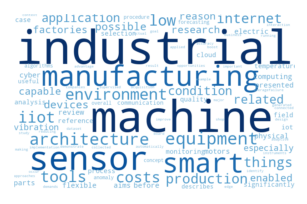

Topic 1 (B)


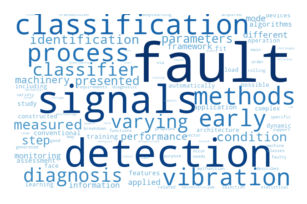

Topic 2 (C)


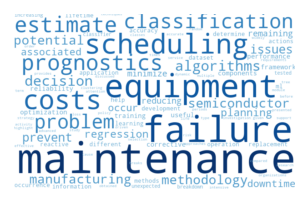

Topic 3 (D)


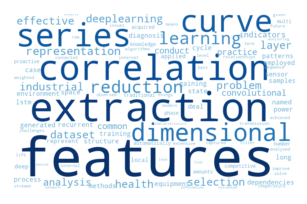

Topic 4 (E)


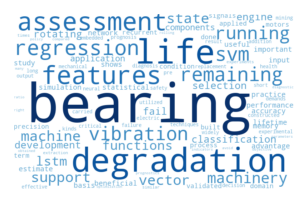

Topic 5 (F)


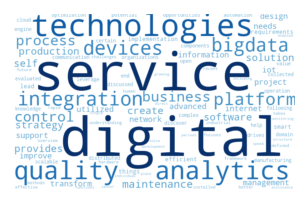

Topic 6 (G)


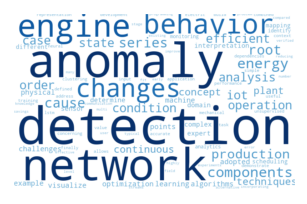

Topic 7 (H)


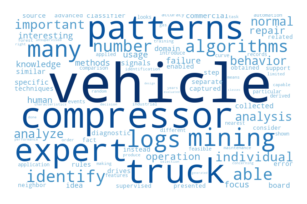

Topic 8 (I)


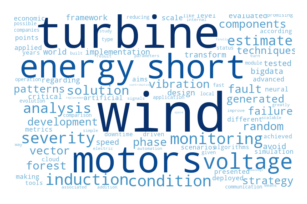

Topic 9 (J)


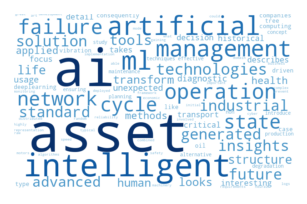

In [22]:
from wordcloud import WordCloud

prepare_fig(1, 1)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        width=395,
        height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()


## Visualization

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 151 samples in 0.000s...
[t-SNE] Computed neighbors for 151 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 151 / 151
[t-SNE] Mean sigma: 0.273153
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.261673
[t-SNE] KL divergence after 1000 iterations: 0.645141


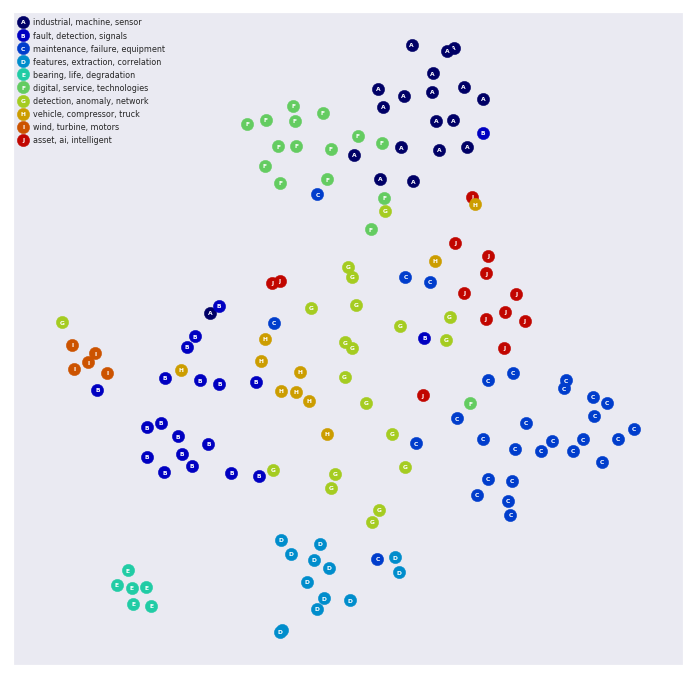

In [25]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(n_components=10, random_state=seed).fit_transform(tfidf_matrix)

# Learn model
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=20)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8)

plt.show()

A Hybrid Deep Representation Learning Model for Time Series Classification and Prediction


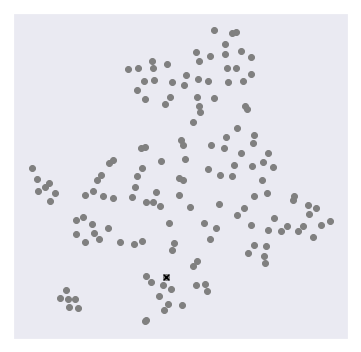

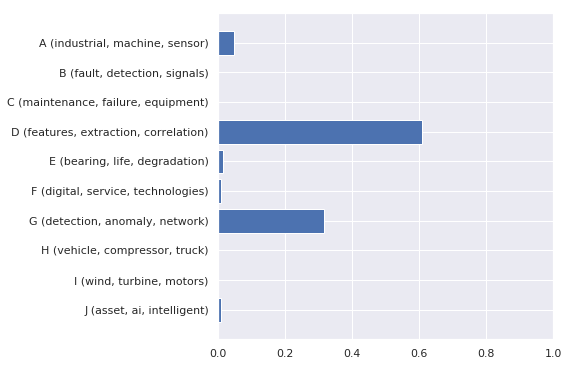

Rapid increase in connectivity of physical sensors and Internet of Things (IoT) systems is enabling large-scale collection of time series data, and the data represents the working patterns and internal evolutions of observed objects. Recognizing and forecasting the underlying high-level states from raw sensory data are useful for daily activity recognition of humans and predictive maintenance of machines. Deep Learning (DL) methods have been proved efficient in computer vision, natural language processing, and speech recognition, and these model are also applied to time series analysis. Since time series are multi-dimensional and sequential with long-term temporal dependency, current DL-based model could not well learn the spatial and temporal features inside and between states, thus there is still plenty of room for improvement of recognizing and predicting high-level states. In this paper, a hybrid deep architecture named Long-term Recurrent Convolutional LSTM Network (LR-ConvLSTM) i

In [26]:
def on_select(i):
    p = papers[i]
    print(p.title)
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(pos.T[0], pos.T[1], c='.5')
    plt.scatter(pos[i,0], pos[i,1], c='0', marker='x')
    plt.show()

    top_words = np.argsort(topic2token, axis=1)[:,::-1]
    ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]
    
    prepare_fig(1, 2)
    plt.barh(range(num_topics), doc2topic[i])
    plt.xlim(0, 1)
    plt.ylim(num_topics, -1)
    plt.yticks(range(num_topics), ticks)
    plt.show()
    
    print(p.abstract)

options = sorted([(p.title.strip()[:50], i) for i, p in enumerate(papers)])
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '1500px'
widget